In [5]:
# IMPORTING LIBRARIES AND DEFINE IMPORT FUNCTION

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
from scipy import signal

def importWAV(filename):
    samplerate, rawData = wavfile.read(filename)
    
    time = np.linspace(0, rawData.shape[0]/samplerate, rawData.shape[0])   
    
    data = {'left':rawData[:, 0],'right':rawData[:, 1]}
    return time,data

In [52]:
# Amplifier Code

# Resistor values (Ohm)
R_1 = 100
R_2 = 20E3
R_3 = 47E3
R_4 = 200
R_5 = 2E3

# Capacitor values (F)
C_1 = 680E-12
C_2 = 0.22E-6
C_3 = 1E-9

def Z_c(C, f):
    """
    Capacitor impedance
    """
    
    return 1 / (2 * np.pi * f * C * complex(0, 1))


def VDG(Z_1, Z_2):
    """
    Gain factor for voltage divider Op-amp circuit
    """

    return (Z_1 + Z_2) / Z_1


def VDF(Z_1, Z_2):
    """
    Voltage divider circuit gain factor
    """

    return Z_1 / (Z_2 + Z_1)


def c_amp(f):
    """
    Final complex amplification factor for entire circuit
    """
    
    return VDG(R_1, 1/(1/R_2 + 1/Z_c(C_1, f))) * VDF(R_3, Z_c(C_2, f)) * VDG(R_4, 1/(1/R_5 + 1/Z_c(C_3, f)))


def amplification(c_amp):
    """
    Converts complex amplification factor to real amplification factor
    """
    
    return np.sqrt(c_amp * c_amp.conjugate())

def phase(c_amp):
    """
    Converts complex amplification factor to phase shift
    """

    # c_amp lies in Q1 of complex plane
    if c_amp.real >= 0 and c_amp.imag >= 0:
        return np.arctan(c_amp.imag / c_amp.real)
    
    # c_amp lies in Q2 of complex plane
    elif c_amp.real < 0 and c_amp.imag >= 0:
        return -np.pi + np.arctan(c_amp.imag / c_amp.real)
   
    # c_amp lies in Q3 of complex plane
    elif c_amp.real < 0 and c_amp.imag < 0:
        return np.arctan(c_amp.imag / c_amp.real) - np.pi

    # c_amp lies in Q4 of complex plane
    else:
        return np.arctan(c_amp.imag / c_amp.real)

/var/folders/rg/hh4cb_xd5_74c2r0hymqq4jm0000gn/T/ipykernel_5032/28373413.py:9: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, rawData = wavfile.read(filename)


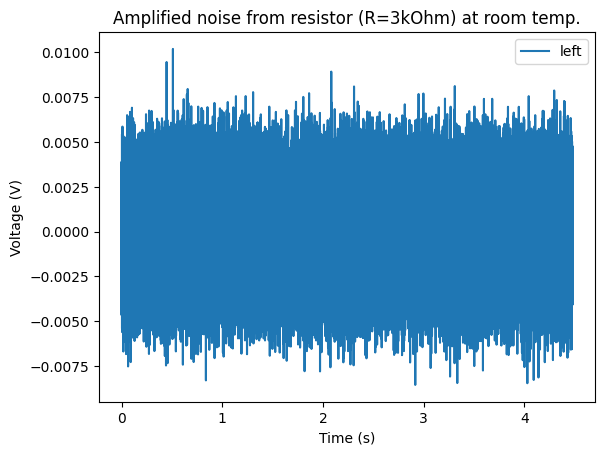

In [66]:
time,data = importWAV('JN_Circ0.wav')

v_data = {'left': [], 'right': []}

v_data['left'] = data['left'] / 8.695
v_data['right'] = data['right'] / 8.695

plt.figure()
plt.plot(time, v_data['left'], label='left')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('Amplified noise from resistor (R=3kOhm) at room temp.')

plt.legend()

/var/folders/rg/hh4cb_xd5_74c2r0hymqq4jm0000gn/T/ipykernel_5032/2853867816.py:20: RuntimeWarning: divide by zero encountered in divide
  return 1 / (2 * np.pi * f * C * complex(0, 1))
/var/folders/rg/hh4cb_xd5_74c2r0hymqq4jm0000gn/T/ipykernel_5032/2853867816.py:20: RuntimeWarning: invalid value encountered in divide
  return 1 / (2 * np.pi * f * C * complex(0, 1))


Max is at point number 0
Sum of PSD within rng points of peak is 0
Bin size is 39.0625
Total power with rng points of peak is 0.0
Average noise power density over the stated range is (3.1247483170289305e-17+0j)


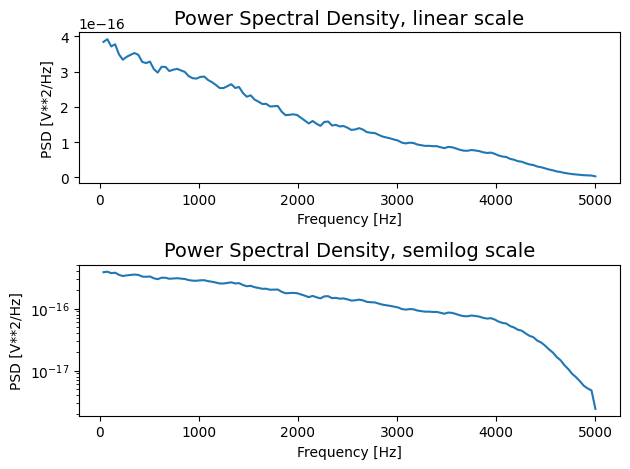

In [67]:
# Periodogram and Welch are two techniques for calculating power spectra, with advantages and disadvantages.
# It is easy to calculate an averaged power spectrum using Welch

fs = 10000

#f, Pxx_den = signal.periodogram(v_data['right'], fs, 'flattop', scaling='density')
f, Pxx_den = signal.welch(v_data['left'], fs, nperseg=256)

Pxx_den = (np.sqrt(Pxx_den) / amplification(c_amp(f))) ** 2

maxloc = np.argmax(Pxx_den)

print("Max is at point number",maxloc)

rng=20

peaksum = sum(Pxx_den[(maxloc-rng):(maxloc+rng)])

print("Sum of PSD within rng points of peak is",peaksum)

binsize = f[1]-f[0]

print("Bin size is",binsize)

sinepower = peaksum*binsize

print("Total power with rng points of peak is",sinepower)

noisepowerden = np.average(Pxx_den[maxloc+100:maxloc+100000]) # Make sure this does not include elements beyond the length of Pxx_den

print("Average noise power density over the stated range is",noisepowerden)


fig, (ax1, ax2) = plt.subplots(2)

ax1.set_xlabel('Frequency [Hz]', fontsize=10)
ax1.set_ylabel('PSD [V**2/Hz]', fontsize=10)
ax1.set_title('Power Spectral Density, linear scale', fontsize=14)
ax2.set_xlabel('Frequency [Hz]', fontsize=10)
ax2.set_ylabel('PSD [V**2/Hz]', fontsize=10)
ax2.set_title('Power Spectral Density, semilog scale', fontsize=14)

ax1.plot(f, Pxx_den)
ax2.semilogy(f,Pxx_den)

fig.tight_layout()